# 논문 내 설정 요약

- **이미지 리사이즈 및 크롭**
  - 이미지의 짧은 변을 $[256, 480]$ 사이 랜덤하게 샘플링하여 크기 조정
  - 이후 $224 \times 224$ 크기의 크롭을 랜덤하게 선택 및 수평 반전
  - 각 픽셀의 평균값을 뺌
- **색상 증가**
  - 표준 색상 증가 기법 사용
- **배치 정규화 (Batch Normalization, BN)**
  - 각 컨볼루션 후와 활성화 전 배치 정규화 적용
- **가중치 초기화**
  - 가중치 초기화는 [13] 연구와 동일하게 적용
- **학습 파라미터**
  - **Optimizer:** SGD (Stochastic Gradient Descent) 사용
  - **Mini-batch size:** 256
  - **Learning rate:** 처음에는 0.1로 시작, 에러가 수렴하면 10배씩 감소
  - **Iteration:** 최대 $60 \times 10^{4}$ 번 반복
  - **Weight decay:** 0.0001
  - **Momentum:** 0.9
  - **Dropout:** 사용하지 않음
- **테스트 방법**
  - **1st stage:** 표준 10-crop 테스트 사용
  - **Best results:** 여러 스케일({224, 256, 384, 480, 640})에서 Fully-convolutional form으로 학습된 모델 평균 점수 사용

# Data Prepering

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:19<00:00, 8776831.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Modeling

## Residual Block

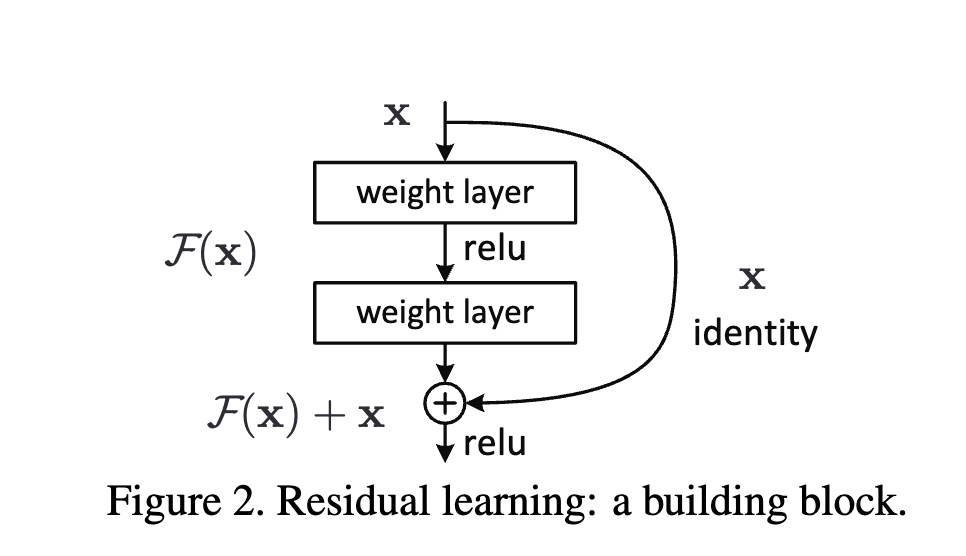

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

## ResNet

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


# Training

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.0938
Epoch [2/10], Loss: 0.9747
Epoch [3/10], Loss: 0.8684
Epoch [4/10], Loss: 0.6896
Epoch [5/10], Loss: 1.1133
Epoch [6/10], Loss: 0.2155
Epoch [7/10], Loss: 0.0963
Epoch [8/10], Loss: 0.5931
Epoch [9/10], Loss: 0.6479
Epoch [10/10], Loss: 0.1322


# Testing

In [6]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


Accuracy of the model on the test images: 76.16%
